In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import random
import math
import statistics as st
import numpy as np

In [3]:
class Player:
    def __init__(self,name):
        self.name = name
    
    def set_game(self, game):
        self.game = game
    
    def take_turn(self):
        rolls = [] 
        while self.will_roll(rolls):
            roll = self.game.get_roll()
            if roll in self.game.bust_numbers:
                return 0
            else:
                rolls.append(roll)
        return sum(rolls)
    
    def will_roll(self):
        return False
    

In [4]:
class TimidPlayer(Player):
    def will_roll(self,rolls):
        return len(rolls) <= 0

class RandomPlayer(Player):
    def will_roll(self,rolls):
        return random.randint(1,6) > 1

class HighRollingPlayer(Player):
    def will_roll(self,rolls):
        return sum(rolls) <= 50

            

In [5]:
class PigGame:
    def __init__(self, players, turn_limit=math.inf, target=100, bust_numbers=[1]):
        self.players = players
        self.turn_limit = turn_limit
        def get_d6():
            return random.randint(1,6)
        self.get_roll = get_d6
        self.bust_numbers = bust_numbers
        self.target = target
    

        
    def play_a_round(self):
        self.scores = [0]*len(self.players)
        for i in range(self.turn_limit):
            for index, player in enumerate(self.players):
                self.scores[index] += player.take_turn()
            winners = [(player,score) for player, score in zip(self.players, self.scores) if score >= self.target]
            if len(winners) >0:
                return winners
        max_score = max(self.scores)
        return [(player,score) for player, score in zip(self.players, self.scores) if score == max_score]


In [6]:
timmy = TimidPlayer('Timmy')
randy = RandomPlayer("Randy")
high_roller = HighRollingPlayer("HighRoller")
players = [timmy, randy, high_roller]
results = {}
for player in players:
    this_game = PigGame([player],7,math.inf)
    player.set_game(this_game)
    results[player.name] = []
    for i in range(1000):
        returned = this_game.play_a_round()
        results[player.name].append(returned[0][1])
    del this_game

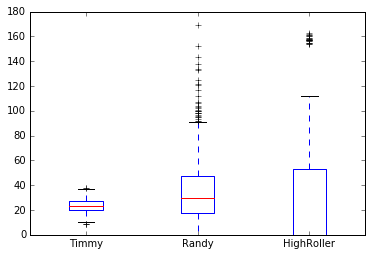

In [7]:
player_names = [player.name for player in players]
results_list = [results[name] for name in player_names]
plt.boxplot(results_list)
plt.xticks([1,2,3],player_names)
plt.show()

It seems to me the the information that should be the most important in determining whether to roll again should be the number of points at risk. The odds of each roll being a bust are independant of the history of the rolls but the number of points one stands to gain or lose does change. I'll build a player that takes variable values for the limit of their risk tolerance and determine which is the most sucessful.

In [8]:
class VariableTolerancePlayer(Player):
    def __init__(self,tolerance_limit,*args):
        self.tolerance = tolerance_limit
        super().__init__(*args)
        
    def will_roll(self,rolls):
        return sum(rolls) <= self.tolerance
    

In [9]:
tolerance_results = {}
for tolerance in range (100):
    player = VariableTolerancePlayer(tolerance,tolerance)
    this_game = PigGame([player],7,math.inf)
    player.set_game(this_game)
    tolerance_results[player.name] = []
    for i in range(6000):
        returned = this_game.play_a_round()
        tolerance_results[player.name].append(returned[0][1])
    del this_game
    del player

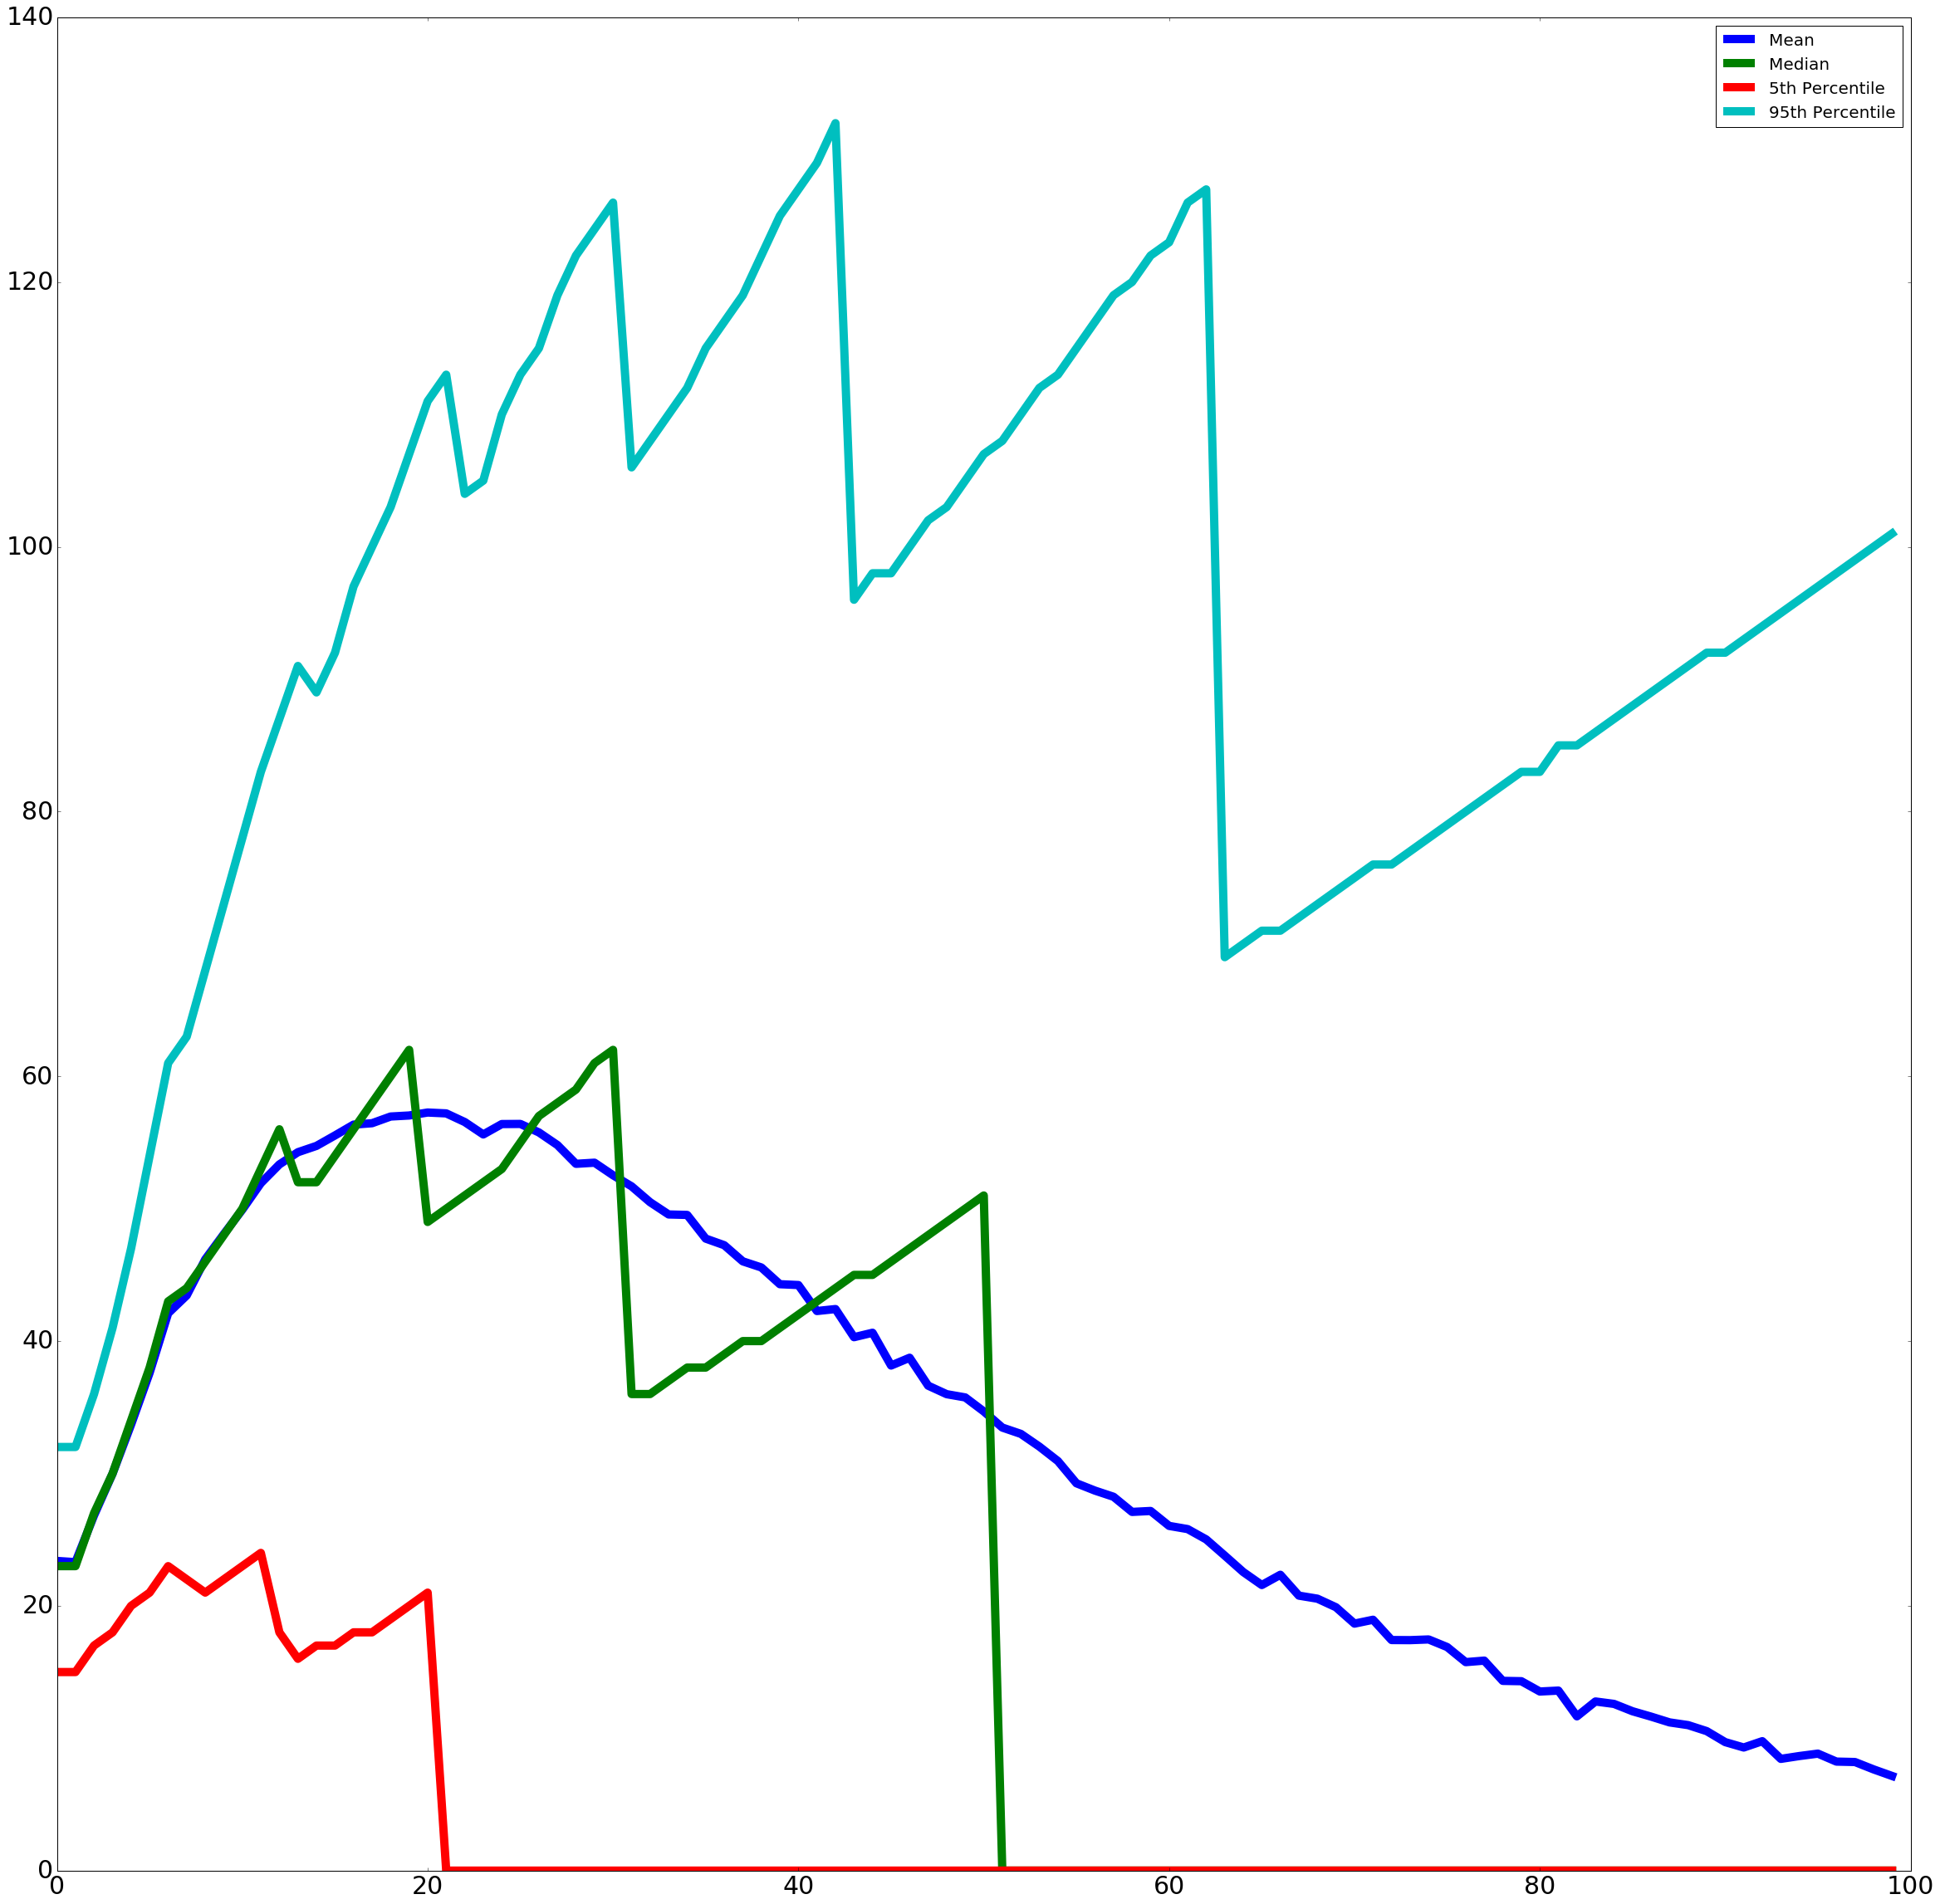

In [10]:
mean_list = [st.mean(tolerance_results[name]) for name in range(100)]
median_list= [st.median(tolerance_results[name]) for name in range(100)]
p95_list= [np.percentile(tolerance_results[name],95) for name in range(100)]
p5_list= [np.percentile(tolerance_results[name],5) for name in range(100)]
plt.figure(figsize = (40,40))
plt.plot(range(100),mean_list,range(100),median_list,range(100),p5_list,range(100),p95_list,linewidth = 10)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(["Mean","Median","5th Percentile","95th Percentile"],fontsize=20)
plt.show()

In [11]:
max_mean = max(mean_list)
max_mean_index = [index for index, value in enumerate(mean_list) if value == max_mean]
max_median = max(median_list)
max_median_index = [index for index, value in enumerate(median_list) if value == max_median]
print (max_mean_index,max_mean)
print(max_median_index,max_median)

[20] 57.26566666666667
[19, 30] 62.0


Lets make a learning player and compare the 2 players


In [27]:
class LearningPlayer(Player):
    def __init__(self,knowledge=None,*args):
        if knowledge == None:
            self.knowledge = {}
        else:
            self.knowledge = knowledge
        self.turn_num = 0
        self.plays = {}
        super().__init__(*args)
        
    def take_turn(self):
        self.turn_num +=1
        return super().take_turn()
        
    def will_roll(self,rolls):
        params = (len(rolls),sum(rolls),self.game.scores[0],self.turn_num)
        this_move = None
        if params in knowledge:
            this_move = random.choice(knowledge[params])
        else:
            this_move = bool(random.getrandbits(1))
        self.plays[params]= this_move
        return this_move
    
    def game_over(self,result):
        if result =="win":
            for key in self.plays:
                if key not in self.knowledge:
                    self.knowledge[key] = [True,False]
                self.knowledge[key].append(self.plays[key])
        elif result == "loss":
            for key in self.plays:
                if key not in self.knowledge:
                    self.knowledge[key] = [True,False]
                self.knowledge[key].remove(self.plays[key])
                if self.plays[key] not in self.knowledge[key]:
                    self.knowledge[key].append(self.plays[key])
        return self.knowledge.copy()
                
            

In [ ]:
knowledge = {}
for _ in range(100000):
#     print(knowledge)
    tol_player = VariableTolerancePlayer(19,"var19")
    learning_player = LearningPlayer(knowledge,"learning")
    tol_game = PigGame([tol_player],7,math.inf)
    tol_player.set_game(tol_game)
    learn_game = PigGame([learning_player],7,math.inf)
    learning_player.set_game(learn_game)
    tol_returned = tol_game.play_a_round()
    learn_returned = learn_game.play_a_round()
    tol_final = tol_returned[0][1]
    learn_final = learn_returned[0][1]
    if learn_final > tol_final:
        knowledge = learning_player.game_over("win")
    elif learn_final < tol_final:
        knowledge = learning_player.game_over("loss")
    else:
        knowledge = learning_player.game_over("tie")
    del tol_game
    del learn_game
    del tol_player
    del learning_player


In [ ]:
know_keys = list(knowledge.keys())
know_keys.sort(key = lambda x:x[1])
for each_key in know_keys:
    ratio = sum(knowledge[each_key])/len(knowledge[each_key])
    if ratio != .5:
        print(each_key,ratio)

In [ ]:
know_keys = list(knowledge.keys())
know_keys.sort(key = lambda x:knowledge[x])
for each_key in know_keys:
    ratio = sum(knowledge[each_key])/len(knowledge[each_key])
    if ratio != .5:
        print(each_key,ratio)